# Analysis - Important Features

This notebook contains analysis of the most important features of our data in terms of predicting revenue from a visit to the online store.

First we determine the most important features.  Next we explore the relationship between these features and the amount of revenue generated from a visit to the store.

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from joblib import dump, load

In [3]:
df = pd.read_csv('../Data/data4.csv', dtype={'fullVisitorId': 'str'})
df.drop('Unnamed: 0', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717217 entries, 0 to 717216
Data columns (total 24 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   channelGrouping                               717217 non-null  object 
 1   device.browser                                717217 non-null  object 
 2   device.deviceCategory                         717217 non-null  object 
 3   device.isMobile                               717217 non-null  bool   
 4   device.operatingSystem                        717217 non-null  object 
 5   geoNetwork.networkDomain                      717217 non-null  object 
 6   revenue_usd                                   717217 non-null  float64
 7   time_of_day                                   717217 non-null  object 
 8   totals.hits                                   717217 non-null  int64  
 9   totals.pageviews                              71

After importing the data set, separate into multiple DataFrames: One for visits that end with a purchase, and one for visits where no purchase is made.  This will be useful in our analysis of features.

In [4]:
purchase = df.loc[df['revenue_usd'] != 0]
no_purchase = df.loc[df['revenue_usd'] == 0]

The top 20 features from the final Random Forest model are shown below.  We will analyze the data in the most important categories/features below.

In [5]:
top_features = load('../Data/top_features.joblib')
top_features

,feature,importance
6,visitNumber,0.344964
2,totals.pageviews,0.225344
182,cluster_label,0.074352
181,sil_score,0.059625
1,totals.hits,0.053662
10,channelGrouping_Direct,0.040644
3,totals.sessionQualityDim,0.038069
4,totals.timeOnSite,0.029292
7,product_price,0.029018
45,geoNetwork.networkDomain_comcastbusiness.net,0.016827


# Top 10 Features

Here we visualize the top 10 features, sorted by importance in our random forest model.  We exclude the results from our clustering algorithm in this chart so that only direct customer attributes are visualized.

In [13]:
tf = top_features.head(13).reset_index().drop('index', axis=1)
tf.drop([2, 3, 4], inplace=True)
tf = tf.reset_index().drop('index', axis=1)
tf

,feature,importance
0,visitNumber,0.344964
1,totals.pageviews,0.225344
2,channelGrouping_Direct,0.040644
3,totals.sessionQualityDim,0.038069
4,totals.timeOnSite,0.029292
5,product_price,0.029018
6,geoNetwork.networkDomain_comcastbusiness.net,0.016827
7,product_category_Apparel,0.015837
8,device.operatingSystem_Chrome OS,0.011745
9,product_category_Office,0.011432


Now graph the importances of each feature.  This shows that the number of visits to the online store is by far the most important feature in predicting revenue.  This makes sense; why would a customer return to the store many times if they have no interest in buying a product there?

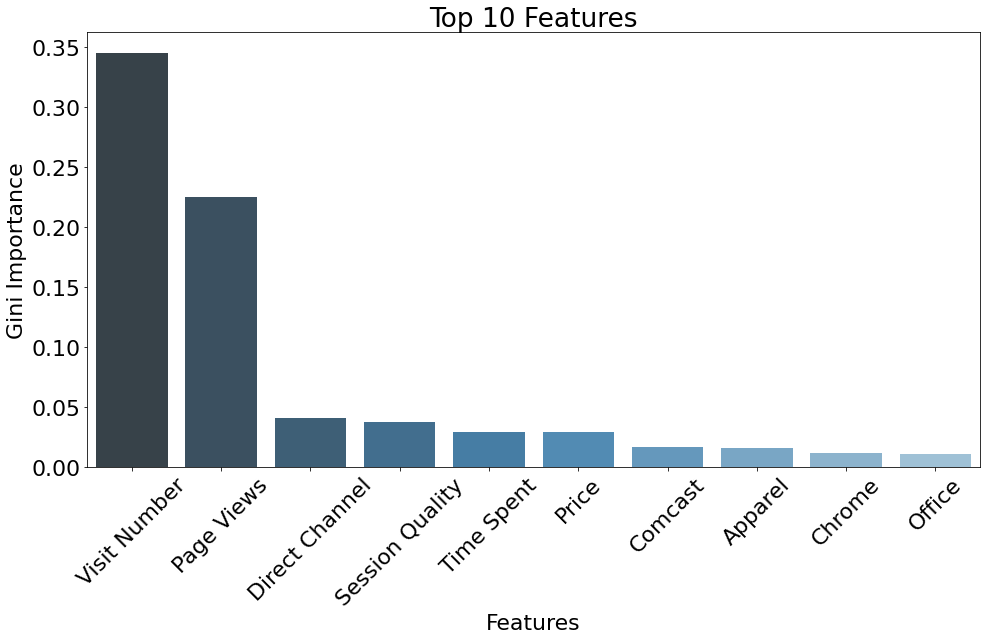

In [21]:
#Format Feature Names for Graph
tf_labels = ['Visit Number', 'Page Views', 'Direct Channel', 'Session Quality', 'Time Spent', 'Price', 'Comcast', 'Apparel', 'Chrome', 'Office']

#Graph
plt.subplots(figsize=(16, 8))

plt.xticks(rotation=45)

plt.title('Top 10 Features')
ax = sns.barplot(x=tf_labels, y='importance', data=tf, palette='Blues_d')

plt.ylabel('Gini Importance')
plt.xlabel('Features')
plt.rcParams.update({'font.size': 22})

Now we will visualize the relationships between these top features and revenue:

# Number of Visits to the Store

What is the relationship between revenue and number of visits to the store a customer has made?  Here we only consider the visits that result in a purchase.

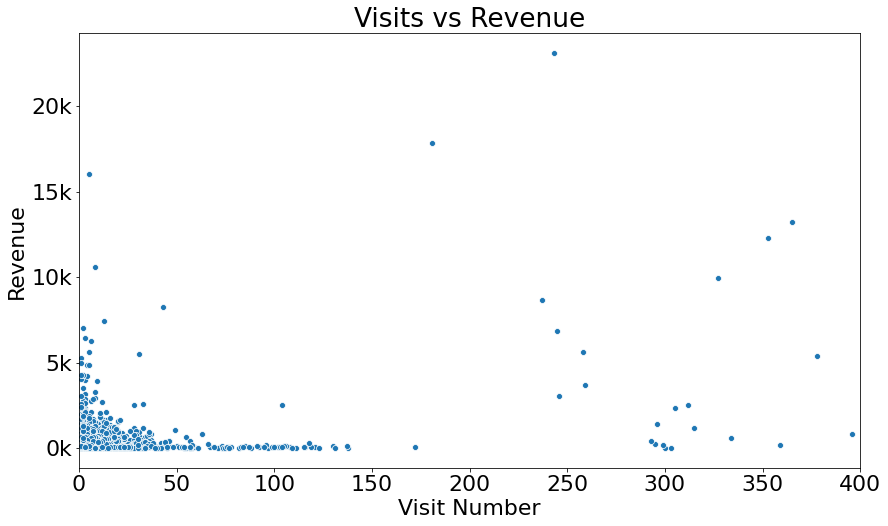

In [32]:
# Revenue vs Visits to Store
plt.subplots(figsize=(14, 8))
ax = sns.scatterplot(x='visitNumber', y='revenue_usd', data=purchase)
plt.xlim(0, 400)
plt.ylabel('Revenue')
plt.xlabel('Visit Number')
plt.title('Visits vs Revenue')
plt.rcParams.update({'font.size': 22})
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: str(round(y / 1000)) + 'k'))

We can see that most purchases are made within the first 30 or so visits to the Google store.  Large purchases are likely to be made in the first ~20 visits to the store.  As visits increase past 50, purchase amounts grow smaller.  This could be attributed to customers that repeatedly visit the store for small goods that wear out quickly like earbuds, chargers, and gift cards.

Also note that there are a few customers that visited the store hundreds of times in our data collection period.  These customers tended to spend more.  These outlier observations could be negatively impacting the predictive power of our model.  In further iterations of this project we will consider removing these visits from the dataset.

Now we consider the median visit number for visits that end in purchases vs those that do not.  We see that the average number of visits for those that make a purchase (2 visits) is almost double that of those that do not make a purchase.  We can infer that many customers only go to the store once, decide they do not want a Google product, then never return to the store.

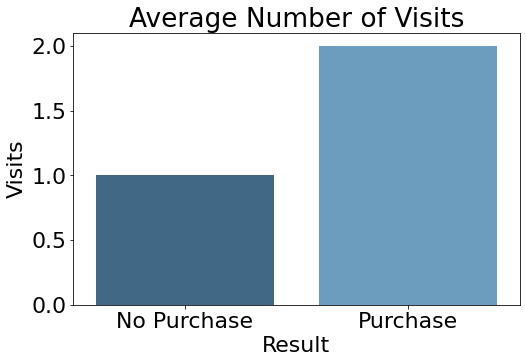

In [39]:
plt.subplots(figsize=(8, 5))
ax = sns.barplot(x=['No Purchase', 'Purchase'], 
                 y=[no_purchase['visitNumber'].median(), 
                    purchase['visitNumber'].median()], 
                 palette='Blues_d')
# plt.xlabel('Visit Type')
plt.ylabel('Visits')
plt.xlabel('Result')

plt.title('Average Number of Visits')
plt.rcParams.update({'font.size': 22})

# Number of Pages Viewed in Visit to the Store

Now examine the number of pages viewed, and its relationship with revenue.  This appears to have a negative relationship with revenue.  As page views pass 100, revenue tends to drop.

We will consider excluding outlier page views from future iterations of modeling.

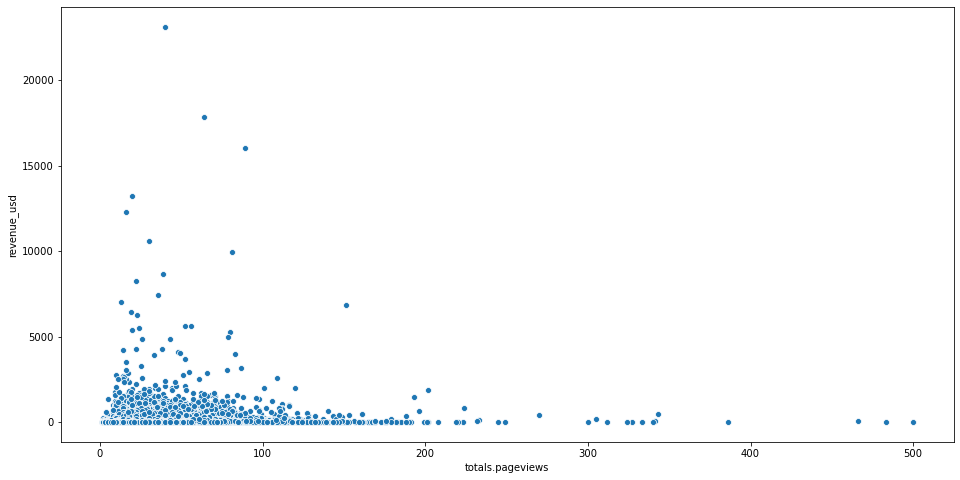

In [7]:
# Revenue vs Pages Viewed on Site
plt.subplots(figsize=(16, 8))
ax = sns.scatterplot(x='totals.pageviews', y='revenue_usd', data=df)

# Chanel Grouping

How do people get to the Google store?  And how much do they spend once they get there?

Here we find that 'Display' ads (banner ads and similar) lead to high average purchase sizes.  Additionally, customers that navigate directly to the google store purchase large amounts on average.

On the other hand, social media and affiliate marketing tends to lead to smaller purchases in general.

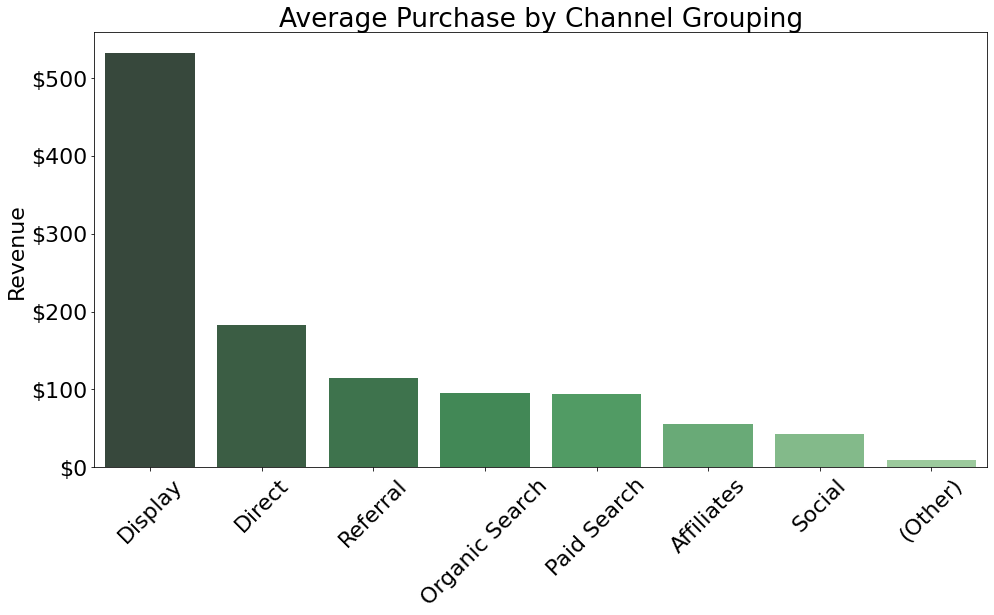

In [46]:
channel_purch = purchase.groupby('channelGrouping').mean().sort_values(by='revenue_usd', ascending=False)

#Graph
plt.subplots(figsize=(16, 8))
ax = sns.barplot(x=channel_purch.index, y='revenue_usd', data=channel_purch, palette='Greens_d')


plt.xticks(rotation=45)

plt.title('Average Purchase by Channel Grouping')

plt.ylabel('Revenue')
plt.xlabel('')
plt.rcParams.update({'font.size': 22})
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: '$' + str(round(y))))

Average purchase size only accounts for half of the story, however.  Here we examine which channels lead to the highest percent of purchases of any size.

Here we see that referrals are much more likely to lead to a purchase than any other kind of channel.  Referrals also have the 3rd highest average purchase size, so this is a valuable channel.

Even though display ads have high average purchase sizes, we see here that they are less likely to convince a customer to actually make that purchase.

Social media and affiliate marketing attract many customers who do not end up making a purchase.  Even when they do make a purchase, it is smaller on average than customers acquired from other channels.

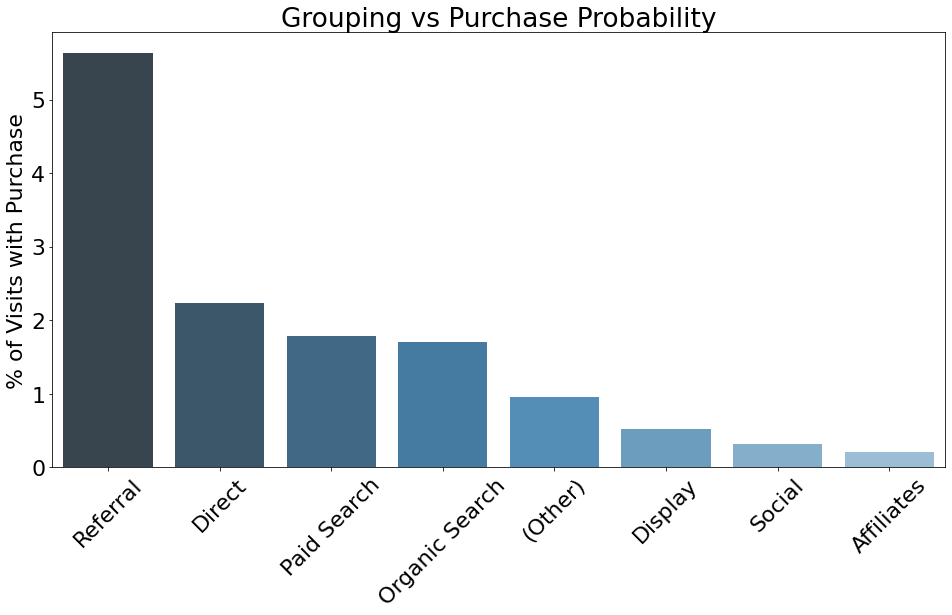

In [43]:
channel_count_p = purchase.groupby('channelGrouping').count()
channel_count_p['purchase_count'] = channel_count_p['visitNumber']
channel_count_p = channel_count_p[['purchase_count']]

channel_count_np = no_purchase.groupby('channelGrouping').count()
channel_count_np['non_purchase_count'] = channel_count_np['visitNumber']
channel_count_np = channel_count_np[['non_purchase_count']]


channel_count = pd.concat([channel_count_p, channel_count_np], axis=1)
channel_count['percent_purchase'] = channel_count['purchase_count'] / (channel_count['purchase_count'] + channel_count['non_purchase_count']) * 100
channel_count.sort_values(by='percent_purchase', ascending=False, inplace=True)


#Graph
plt.subplots(figsize=(16, 8))
ax = sns.barplot(x=channel_count.index, y='percent_purchase', data=channel_count, palette='Blues_d')


plt.xticks(rotation=45)

plt.title('Grouping vs Purchase Probability')

plt.ylabel('% of Visits with Purchase')
plt.xlabel('')
plt.rcParams.update({'font.size': 22})

# Time Spent in the Online Store

Time spent on the site has a similar relationship to revenue as number of pages visited.  This is to be expected, as more time on the site is likely correlated to how many pages are viewed in a given visit.

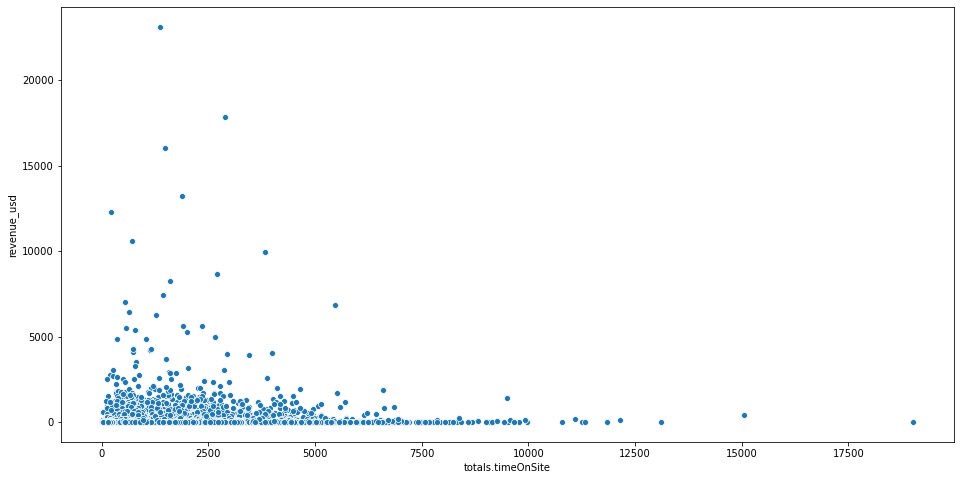

In [11]:
# Revenue vs Time Spent on Site
plt.subplots(figsize=(16, 8))
ax = sns.scatterplot(x='totals.timeOnSite', y='revenue_usd', data=df)

# Price of the Last Product Viewed

Most products viewed are relatively cheap (<$100). Some products have much higher price points.  These outliers may be removed from future iterations of this project.

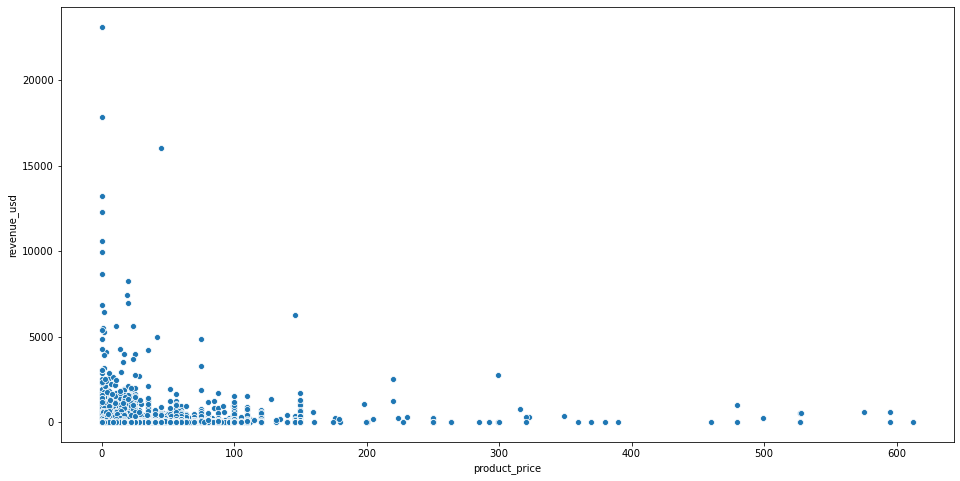

In [12]:
# Revenue vs Price of Last Product
plt.subplots(figsize=(16, 8))
ax = sns.scatterplot(x='product_price', y='revenue_usd', data=df)

In [13]:
tf = top_features.head(13).reset_index().drop('index', axis=1)
tf.drop([2, 3, 4], inplace=True)
tf = tf.reset_index().drop('index', axis=1)
tf

,feature,importance
0,visitNumber,0.344964
1,totals.pageviews,0.225344
2,channelGrouping_Direct,0.040644
3,totals.sessionQualityDim,0.038069
4,totals.timeOnSite,0.029292
5,product_price,0.029018
6,geoNetwork.networkDomain_comcastbusiness.net,0.016827
7,product_category_Apparel,0.015837
8,device.operatingSystem_Chrome OS,0.011745
9,product_category_Office,0.011432


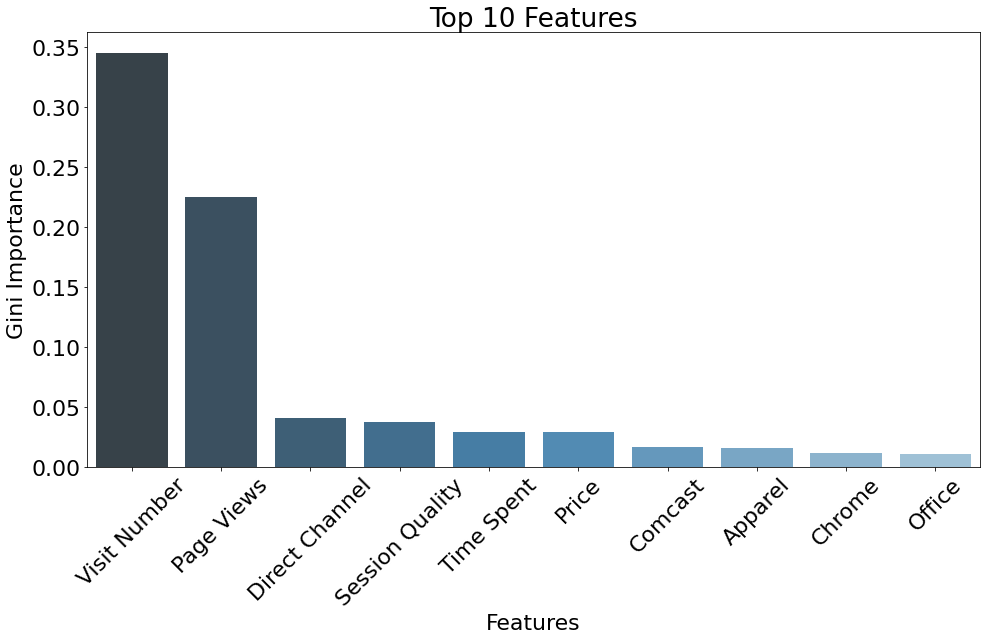

In [21]:
#Format Feature Names for Graph
tf_labels = ['Visit Number', 'Page Views', 'Direct Channel', 'Session Quality', 'Time Spent', 'Price', 'Comcast', 'Apparel', 'Chrome', 'Office']

#Graph
plt.subplots(figsize=(16, 8))

plt.xticks(rotation=45)

plt.title('Top 10 Features')
ax = sns.barplot(x=tf_labels, y='importance', data=tf, palette='Blues_d')

plt.ylabel('Gini Importance')
plt.xlabel('Features')
plt.rcParams.update({'font.size': 22})